# Houses prices competition

This notebook builds a predictive model for predict the sales price of houses, based on data provided on the [House Prices: Advanced Regression Techniques competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview).

In [127]:
# Load dependencies.
import numpy as np
import pandas as pd

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

import scipy.stats as ss

## 1. Load and clean data

In [128]:
# Load train and test data.
test_data_raw = pd.read_csv('./data/test.csv', sep=',')
train_data_raw = pd.read_csv('./data/train.csv', sep=',')

# Take a quick look into the data.
train_data_raw.head(8)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000


In [129]:
# Define a constant for the column to predict.
TARGET = 'SalePrice'

# Define an array with the columns that can't be used in the prediction (based on the docs).
USELESS_COLUMNS = ['Id']

# Check which columns are numerical and which are categorical.
NUMERIC_COLUMNS = []
CATEGORICAL_COLUMNS = []

for column in train_data_raw.columns:
    if (column != TARGET) and (column not in USELESS_COLUMNS):
        if train_data_raw.dtypes[column] == 'object':
            CATEGORICAL_COLUMNS.append(column)
        else:
            NUMERIC_COLUMNS.append(column)

# Define arrays with categorical columns that have score-like values or binary values (based on the docs).
QUALITY_COLUMNS = [
    'BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 
    'GarageCond', 'GarageQual', 'HeatingQC', 'KitchenQual', 'PoolQC'
]
QUALITY2_COLUMNS = ['BsmtExposure']
ROAD_COLUMNS = ['Alley', 'Street']
BINARY_COLUMNS = ['CentralAir', 'PavedDrive']

SCORE_COLUMNS = QUALITY_COLUMNS + QUALITY2_COLUMNS + ROAD_COLUMNS + BINARY_COLUMNS
NON_SCORE_COLUMNS = [x for x in CATEGORICAL_COLUMNS if x not in SCORE_COLUMNS]

# Define tables to convert categorical columns to numeric values.
QUALITY_TO_NUMBER = {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1}
QUALITY2_TO_NUMBER = {"Gd": 4, "Av": 3, "Mn": 2, "No": 1}
ROAD_TO_NUMBER = {"Grvl": 1, "Pave": 2}
BINARY_TO_NUMBER = {"N": 0, "P": 0.5, "Y": 2}

def replace_scores(data):
    convertion_map = {}

    for column in QUALITY_COLUMNS:
        convertion_map[column] = QUALITY_TO_NUMBER
    for column in QUALITY2_COLUMNS:
        convertion_map[column] = QUALITY2_TO_NUMBER
    for column in ROAD_COLUMNS:
        convertion_map[column] = ROAD_TO_NUMBER
    for column in BINARY_COLUMNS:
        convertion_map[column] = BINARY_TO_NUMBER

    return data.replace(convertion_map)

def sanitize_data(data, convert=False):
    # Remove bogus columns.
    data = data.drop(USELESS_COLUMNS, axis=1)

    # Convert categorical columns into numeric ones (if possible).
    if convert:
        data = replace_scores(data)

    # Fill missing data.
    data = data.fillna(0)
    
    return data

train_data = sanitize_data(train_data_raw)
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,0,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,0,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


## 2. Explore data

### 2.1 Numerical columns

In [130]:
# Calculate correlations of numerical columns with the target.
num_corrs = train_data.corr(method ='pearson')[TARGET]
num_corrs = num_corrs.sort_values()

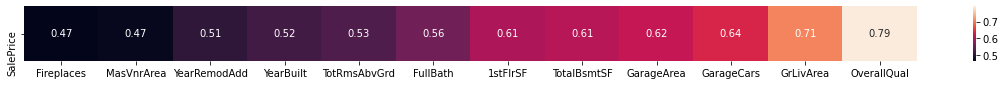

In [131]:
# Draw heatmap for columns with high correlation.
plt.figure(figsize=(20,1))
sns.heatmap(num_corrs[num_corrs >= 0.4].to_frame().drop(TARGET).T, annot=True, fmt='.2f')
plt.show()

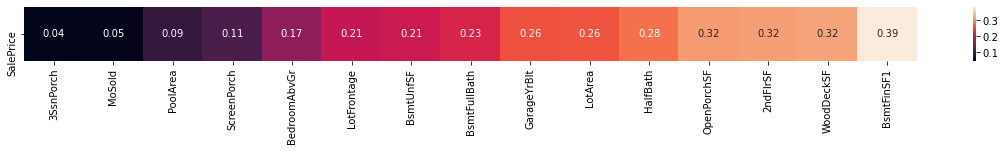

In [132]:
# Draw heatmap for columns with low correlation.
plt.figure(figsize=(20,1))
sns.heatmap(num_corrs[(num_corrs >= 0) & (num_corrs < 0.4)].to_frame().T, annot=True, fmt='.2f')
plt.show()

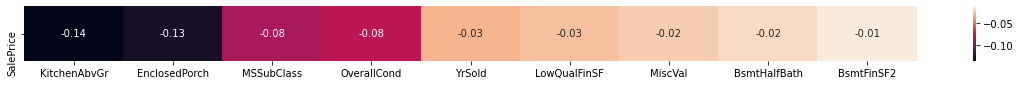

In [133]:
# Draw heatmap for columns with negative correlation.
plt.figure(figsize=(20,1))
sns.heatmap(num_corrs[num_corrs < 0].to_frame().T, annot=True, fmt='.2f')
plt.show()

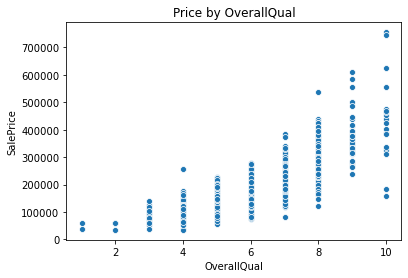

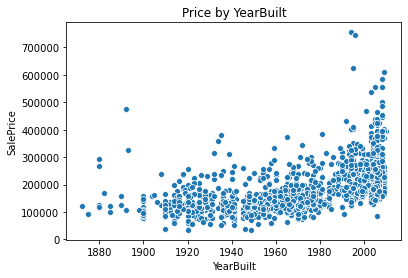

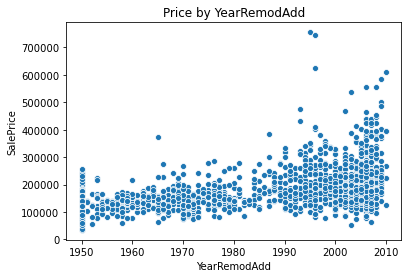

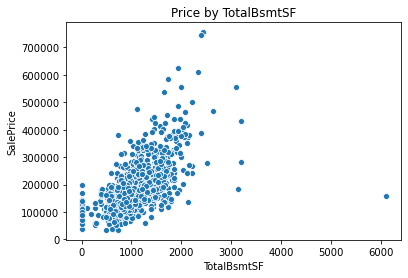

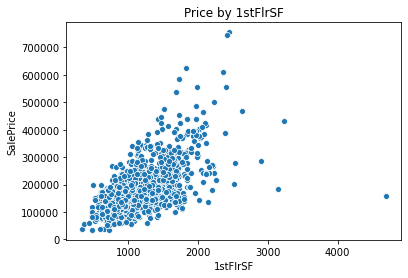

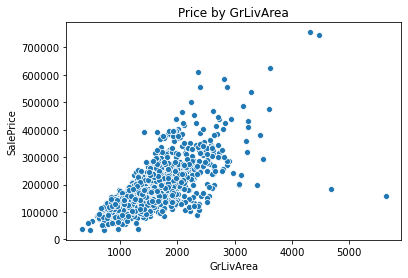

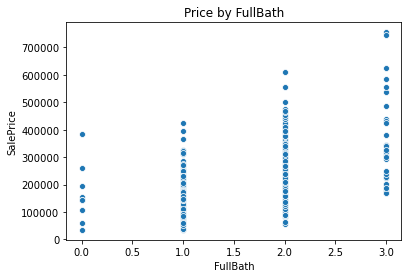

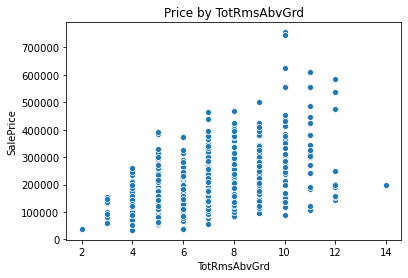

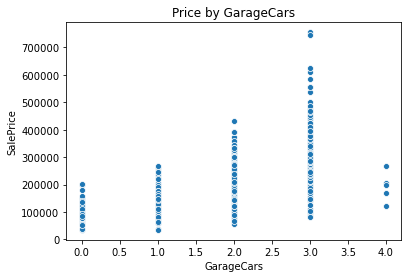

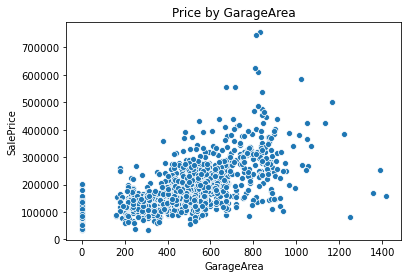

In [134]:
# Draw bar chars for each column whose correlation is superior to 0.5.
for column in NUMERIC_COLUMNS:
    if num_corrs[column] > 0.5:
        plt.figure(figsize=(6,4))
        plt.title("Price by " + column)
        sns.scatterplot(data=train_data, x=column, y=TARGET)

### 3.2 Categorical columns

In [135]:
def cramers_v(confusion_matrix):
    """ Calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calculate correlations of columns with the target
cat_corrs_index = CATEGORICAL_COLUMNS
cat_corrs = pd.Series([0.0] * len(cat_corrs_index), index=cat_corrs_index)
for column in cat_corrs.index:
    confusion_matrix = pd.crosstab(train_data[column], train_data[TARGET]).values
    cat_corrs[column] = cramers_v(confusion_matrix)

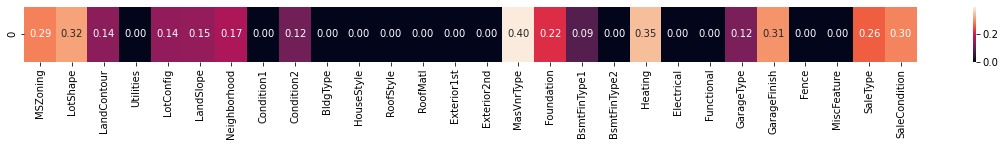

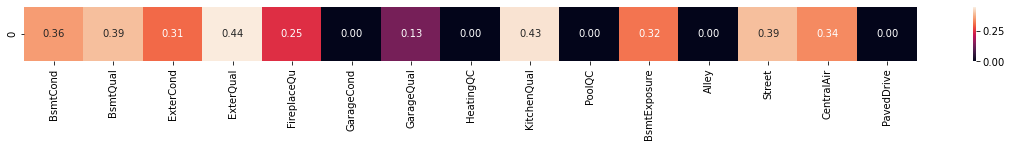

In [136]:
# Draw heatmap for standard categorical columns.
plt.figure(figsize=(20,1))
sns.heatmap(cat_corrs[NON_SCORE_COLUMNS].to_frame().T, annot=True, fmt='.2f')
plt.show()

# Draw heatmap for score-like categorical columns.
plt.figure(figsize=(20,1))
sns.heatmap(cat_corrs[SCORE_COLUMNS].to_frame().T, annot=True, fmt='.2f')
plt.show()

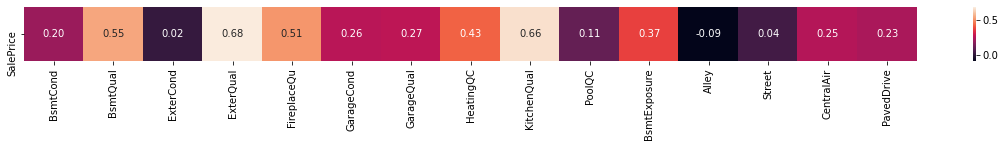

In [137]:
# Convert score-like columns to numbers, and check correlation again.
train_data_w_scores = replace_scores(train_data)
score_corrs = train_data_w_scores[SCORE_COLUMNS + [TARGET]].corr(method ='pearson')[TARGET]

plt.figure(figsize=(20,1))
sns.heatmap(score_corrs.to_frame().drop(TARGET).T, annot=True, fmt='.2f')
plt.show()

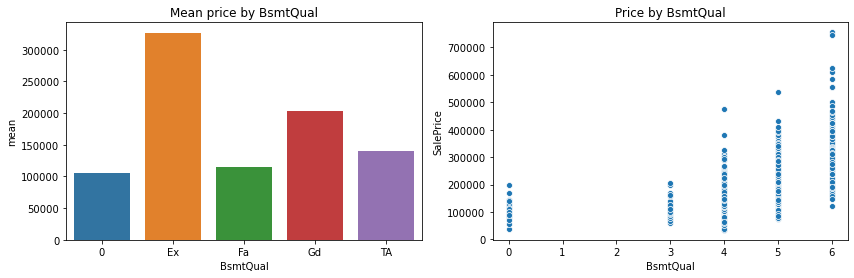

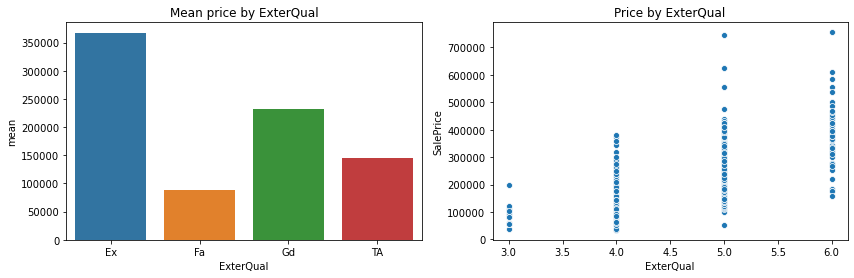

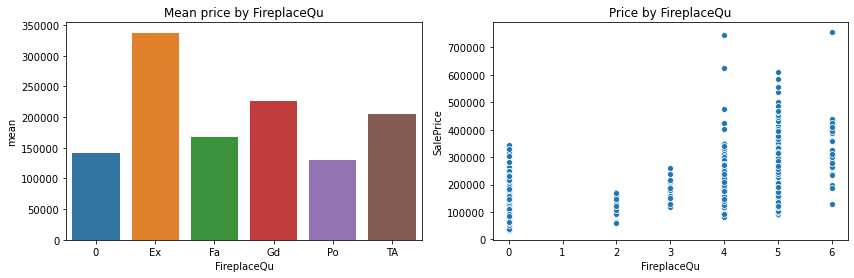

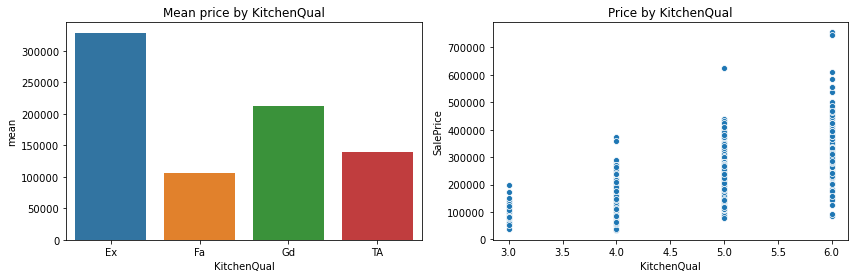

In [138]:
# Draw bar chars for each (score) column whose correlation is superior to 0.5.
for column in SCORE_COLUMNS:
    if score_corrs[column] > 0.5:
        fig, ax =plt.subplots(1,2, figsize=(14,4))

        # Draw bar chart (with mean price).
        column_stats = train_data[[column, TARGET]].groupby(column).agg({TARGET: ['count', 'sum']})
        column_stats['mean'] = column_stats[TARGET]['sum'] / column_stats[TARGET]['count']

        ax[0].set_title("Mean price by " + column)
        sns.barplot(x=column_stats.index, y=column_stats['mean'], ax=ax[0])
        
        # Draw scatter plot chart.
        ax[1].set_title("Price by " + column)
        sns.scatterplot(data=train_data_w_scores, x=column, y=TARGET, ax=ax[1])

## 3. Build models

In [139]:
def train_and_check_errors(X, y):
    # Define settings
    test_size = 0.33
    random_states = [11, 22, 47, 89] 
    
    # Auxiliary variable for store results.
    results = pd.DataFrame(
        np.random.rand(len(random_states), 4), 
        columns=['Linear.Score', 'Linear.CV', 'Ridge.Score', 'Ridge.CV'],
        index=random_states
    )
    
    for random_state in random_states:
        # Separate data into training and testing subsets.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
        # Create and train classifiers.
        linear_regression = LinearRegression()
        ridge_regression = RidgeCV()
        linear_regression.fit(X_train, y_train)
        ridge_regression.fit(X_train, y_train)
    
        # Make predictions.
        y_pred_linear = linear_regression.predict(X_test)
        y_pred_ridge = ridge_regression.predict(X_test)

        # Check the accuracy of the predictions.
        price_mean = np.mean(y_test)
        MSE_linear = np.mean((y_pred_linear - y_test) ** 2)
        RMSE_linear = np.sqrt(MSE_linear)
        MSE_ridge = np.mean((y_pred_ridge - y_test) ** 2)
        RMSE_ridge = np.sqrt(MSE_ridge)

        #results.set_value(2, 'B', 100) 
        results.loc[random_state, 'Linear.Score'] = linear_regression.score(X_test, y_test)
        results.loc[random_state, 'Linear.CV'] = RMSE_linear / price_mean
        results.loc[random_state, 'Ridge.Score'] = ridge_regression.score(X_test, y_test)
        results.loc[random_state, 'Ridge.CV'] = RMSE_ridge / price_mean
        
    print(results)
    print('\n')
    print(results.mean())

### 3.1 Plain regression

In [140]:
# Separate output from input.
X = train_data.drop(TARGET, axis=1)
y = train_data[TARGET].copy()

# Convert categorical columns to numbers.
X = pd.get_dummies(X)

# Run.
train_and_check_errors(X, y)

    Linear.Score  Linear.CV  Ridge.Score  Ridge.CV
11      0.823606   0.200867     0.851357  0.184390
22     -0.228105   0.479640     0.751981  0.215546
47      0.634380   0.264504     0.630650  0.265850
89      0.691321   0.244557     0.741710  0.223707


Linear.Score    0.480300
Linear.CV       0.297392
Ridge.Score     0.743924
Ridge.CV        0.222373
dtype: float64


### 3.2 Regression replacing score columns

In [141]:
# Separate output from input.
X = replace_scores(train_data.drop(TARGET, axis=1))
y = train_data[TARGET].copy()

# Convert categorical columns to numbers.
X = pd.get_dummies(X)

# Run.
train_and_check_errors(X, y)

    Linear.Score  Linear.CV  Ridge.Score  Ridge.CV
11      0.830115   0.197126     0.829977  0.197206
22      0.618035   0.267491     0.738355  0.221388
47      0.563426   0.289032     0.602959  0.275635
89      0.672892   0.251751     0.838303  0.177002


Linear.Score    0.671117
Linear.CV       0.251350
Ridge.Score     0.752398
Ridge.CV        0.217808
dtype: float64


### 3.3 Regression with only numeric columns

In [142]:
# Separate output from input.
X = train_data.drop(CATEGORICAL_COLUMNS, axis=1).drop(TARGET, axis=1)
y = train_data[TARGET].copy()

# Separate data into training and testing subsets.
train_and_check_errors(X, y)

    Linear.Score  Linear.CV  Ridge.Score  Ridge.CV
11      0.789638   0.219356     0.789883  0.219228
22      0.687176   0.242074     0.687946  0.241776
47      0.574329   0.285400     0.574121  0.285469
89      0.795940   0.198840     0.796808  0.198417


Linear.Score    0.711771
Linear.CV       0.236417
Ridge.Score     0.712190
Ridge.CV        0.236223
dtype: float64


### 3.4 Regression with only categorical columns

In [143]:
# Separate output from input.
X = train_data.drop(NUMERIC_COLUMNS, axis=1).drop(TARGET, axis=1)
y = train_data[TARGET].copy()

# Convert categorical columns to numbers.
X = pd.get_dummies(X)

# Run.
train_and_check_errors(X, y)

    Linear.Score     Linear.CV  Ridge.Score  Ridge.CV
11 -1.807217e+24  6.429415e+11     0.763631  0.232520
22 -4.212154e+23  2.808989e+11     0.738536  0.221312
47 -9.659105e+23  4.299176e+11     0.732248  0.226351
89 -2.440652e+24  6.876679e+11     0.786765  0.203261


Linear.Score   -1.408749e+24
Linear.CV       5.103564e+11
Ridge.Score     7.552952e-01
Ridge.CV        2.208611e-01
dtype: float64


### 3.5 Regression with only numeric and score columns

In [144]:
# Separate output from input.
X = replace_scores(train_data.drop(NON_SCORE_COLUMNS, axis=1).drop(TARGET, axis=1))
y = train_data[TARGET].copy()

# Separate data into training and testing subsets.
train_and_check_errors(X, y)

    Linear.Score  Linear.CV  Ridge.Score  Ridge.CV
11      0.785089   0.221715     0.795984  0.216022
22      0.690262   0.240877     0.704455  0.235293
47      0.545777   0.294816     0.576007  0.284837
89      0.810579   0.191575     0.811949  0.190881


Linear.Score    0.707927
Linear.CV       0.237246
Ridge.Score     0.722099
Ridge.CV        0.231758
dtype: float64


### 3.6 Regression with only highly correlated columns

In [145]:
# Separate output from input.
X = replace_scores(train_data.drop(NON_SCORE_COLUMNS, axis=1))
x_corrs = X.corr(method ='pearson')[TARGET]
X = X[x_corrs[x_corrs >= 0.3].index].drop(TARGET, axis=1)

y = train_data[TARGET].copy()

# Run.
train_and_check_errors(X, y)

    Linear.Score  Linear.CV  Ridge.Score  Ridge.CV
11      0.807520   0.209826     0.807649  0.209756
22      0.717330   0.230111     0.717761  0.229936
47      0.617309   0.270608     0.617676  0.270478
89      0.794945   0.199325     0.795449  0.199079


Linear.Score    0.734276
Linear.CV       0.227467
Ridge.Score     0.734634
Ridge.CV        0.227312
dtype: float64


## 4. Make predictions

In [146]:
# Initialize train and test data.
X_train = replace_scores(train_data.drop(NON_SCORE_COLUMNS, axis=1).drop(TARGET, axis=1))
y_train = train_data[TARGET].copy()

test_data = sanitize_data(test_data_raw, True).drop(NON_SCORE_COLUMNS, axis=1)

# Make the predictions.
ridge_regression = RidgeCV()
ridge_regression.fit(X_train, y_train)

test_predictions = ridge_regression.predict(test_data)

# Generate the submission file (to be uploaded to Kaggle).
output = pd.DataFrame({'Id': test_data_raw.Id, 'SalePrice': test_predictions})
output.to_csv('my_submission.csv', index=False)
print("The submission was successfully saved!")

The submission was successfully saved!
